In [ ]:
import numpy as np
import torch
from model import AttentionModel
from attention import trainer
from dcascore import *
import os
import random
from utils import read_fasta_alignment, remove_duplicate_sequences

letter_to_num_conversion = {
    'A': 0,  'C': 1,  'D': 2,  'E': 3,
    'F': 4,  'G': 5,  'H': 6,  'I': 7,  
    'K': 8,  'L': 9, 'M': 10, 'N': 11, 
    'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16,
    'V': 17, 'W': 18,  'Y': 19,
    '-': 20  # Gap symbol
}
# switched here as wel
cwd = os.getcwd()
cwd=cwd.replace(r"\CODE\AttentionDCA_python\src",'')
cwd="C"+cwd[1:]
def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    tensor_data = []
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:
                tensor_data.append(current_slice)
                current_slice = []
        elif line:
            current_slice.append(list(map(float, line.split(','))))
    if current_slice:
        tensor_data.append(current_slice)

    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
def modify_seq(seq,ratio,aa_list=np.arange(22)):
    L=len(seq)
    seq_func=seq.copy()
    nb_change=int(L*ratio)
    ind_change=np.random.choice(np.arange(L),nb_change)
    for i in range(nb_change):
        seq_func[ind_change[i]]=np.random.choice(aa_list)
    return seq_func
def invert_dict(d):
    inverted = {}
    for key, value in d.items():
        if value in inverted:
            inverted[value].append(key)
        else:
            inverted[value] = [key]
    return inverted
def numbers_to_letters(numbers, inverted_dict):
    result = ''
    for number in numbers:
        if number in inverted_dict:
            letters = inverted_dict[number]
            result += random.choice(letters)
        else:
            raise ValueError(f"Number {number} not found in the inverted dictionary.")
    return result
def seq_num_to_letters(file_path,dictionary):
    inv_dict=invert_dict(dictionary)
    seq_array=np.loadtxt(file_path).astype(np.int64)
    letter_seq_array=[]
    for seq in seq_array:
        letter_seq_array.append(numbers_to_letters(seq,inv_dict))
    output_path=file_path.replace(".txt",'')+"output.txt"
    np.savetxt(output_path, np.array(letter_seq_array), fmt='%s')



    
set_seed()
print(cwd)
filename= cwd +"\\CODE\\results\\48_23_hsp70_without_J_300\\"
filename=r"C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\Attention-DCA-main\CODE\AttentionDCA_python\src\results\64_10_jdoms_without_J_500_youss"
print(filename)
#Q_1=read_tensor_from_txt(r"C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\Attention-DCA-main\results\48_23_hsp70_without_J_300\Q_tensor.txt")
Q_1=read_tensor_from_txt(filename + r"\Q_tensor.txt")
K_1=read_tensor_from_txt(filename + r"\K_tensor.txt")
V_1=read_tensor_from_txt(filename + r"\V_tensor.txt")



H,d,N=Q_1.shape
q=V_1.shape[1]
print(Q_1.shape)
print(V_1.shape)



C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\Attention-DCA-main
C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\Attention-DCA-main\CODE\AttentionDCA_python\src\results\64_10_jdoms_without_J_500_youss
torch.Size([64, 10, 63])
torch.Size([64, 21, 21])


In [2]:

model=AttentionModel(H,d,N,q,Q=Q_1,V=V_1,K=K_1)
torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

i_indices = torch.arange(L, device=device).unsqueeze(1)
j_indices = torch.arange(L, device=device).unsqueeze(0)
mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
W = W * mask
    
# Compute Jtens
Jtens = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)

#ranking,JT_np=score(model,Q_1,K_1,V_1)




torch.Size([64, 63, 63])
21
63


In [3]:
from tqdm import tqdm
letter_to_num_ale = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
}
letter_to_num = {
    'A': 0,  'B': 20, 'C': 1,  'D': 2,  'E': 3,
    'F': 4,  'G': 5,  'H': 6,  'I': 7,  'J': 20,
    'K': 8,  'L': 9, 'M': 10, 'N': 11, 'O': 20,
    'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16,
    'U': 20, 'V': 17, 'W': 18, 'X': 20, 'Y': 19,
    '-': 20  # Gap symbol
}


#switched the indexes to minus 1
def prob_cond_unnormalized(aa,prev_aa,J_ten,beta=1):
    i=len(prev_aa)
    sum=0
    for j in range(i):
        sum+=J_ten[aa,prev_aa[j],i,j]
    return np.exp(beta*sum)
def Z_i_prob(aa_pot,prev_aa,J_tens):
    list_prob=[prob_cond_unnormalized(aa,prev_aa,J_tens) for aa in aa_pot ]
    return list_prob
def sample(aa_pot,Z_list):
    Z=np.sum(Z_list)
    Z_list=Z_list/Z
    return np.random.choice(aa_pot,p=Z_list)


def generate_sequence(aa_pot,J):
    L=J.shape[-1]
    aa_sequence=[]
    aa_sequence.append(np.random.choice(aa_pot))
    for i in range(L-1):
        Z_list=Z_i_prob(aa_pot,aa_sequence,J)
        aa_sequence.append(sample(aa_pot,Z_list))
    return np.array(aa_sequence)

def generate_ar_multi_seq(aa_pot,J,nb_seq=4000):
    seq_list=[]
    for i in tqdm(range(nb_seq)):
        #seq_list=np.append(seq_list,np.array([generate_sequence(aa_pot,J)]))
        seq_list.append(generate_sequence(aa_pot,J))
    return np.array(seq_list)
    

#à verifier confusion entre lettres et nombre dans les samples et les listes à la fin


Generative model with pseudo likelihood

In [ ]:
from tqdm import tqdm
letter_to_num_ale = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
}
letter_to_num = {
    'A': 0,  'B': 20, 'C': 1,  'D': 2,  'E': 3,
    'F': 4,  'G': 5,  'H': 6,  'I': 7,  'J': 20,
    'K': 8,  'L': 9, 'M': 10, 'N': 11, 'O': 20,
    'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16,
    'U': 20, 'V': 17, 'W': 18, 'X': 20, 'Y': 19,
    '-': 20  # Gap symbol
}
# switched here as well for the computation of the prob
def initial_sample(L):
    list_nb=np.arange(22)
    init_sample=np.random.choice(list_nb,L)
    return init_sample

def plm_seq(seq,J):
    sum=0
    L=J.shape[-1]
    for i in range(L):
        for j in range(L):
            sum+=J[seq[i],seq[j],i,j]
    return sum

def plm_aa_calc_diff(aa_new,ind_change,seq,J_tens):
    L=J_tens.shape[-1]
    sum=0
    for j in range(L):
        delta_J1=J_tens[aa_new,seq[j],ind_change,j]-J_tens[seq[ind_change],seq[j],ind_change,j]
        delta_J2=J_tens[seq[j],aa_new,j,ind_change]-J_tens[seq[j],seq[ind_change],j,ind_change]
        sum+=delta_J1+delta_J2
    return sum

def plm_aa_calc_diff_alter(aa_new,ind_change,seq,J_tens):
    L=J_tens.shape[-1]
    sum=0
    for j in range(L):
        delta_J1=J_tens[aa_new,seq[j],ind_change,j]
        delta_J2=J_tens[seq[j],aa_new,j,ind_change]
        sum+=delta_J1+delta_J2
    return sum


def plm_ind_change(aa_pot,ind,seq,J,beta=1,old_plm=None,test=False):#probablement false
    if old_plm==None:
        old_plm=plm_seq(seq,J)
    list_aa_plm=np.array([])
    list_aa_plm_alter=np.array([])
    
    for i in range(len(aa_pot)):
        list_aa_plm=np.append(list_aa_plm,plm_aa_calc_diff(aa_pot[i],ind,seq,J))
        list_aa_plm_alter=np.append(list_aa_plm_alter,plm_aa_calc_diff_alter(aa_pot[i],ind,seq,J))
        # print("diff for two sequences",plm_aa_calc_diff(aa_pot[i],ind,seq,J))
        
        if test==True:
            seq_t=seq.copy()
            seq_t[ind]=aa_pot[i]
            print("diff two methods:",old_plm+plm_aa_calc_diff(aa_pot[i],ind,seq,J)-plm_seq(seq_t,J))
    prob_unn=np.exp(beta*list_aa_plm)    #à checker signe dans l'exponentiel
    pro_alter=np.exp(beta*list_aa_plm_alter)
    def assert_no_nan(arr, name="array"):
        """
        Checks if a NumPy array contains any NaNs.
        If it does, raises a ValueError with debug info.
        
        Parameters:
            arr (np.ndarray): Array to check.
            name (str): Optional name to include in the error message.
        """
        if np.isnan(arr).any():
            nan_indices = np.argwhere(np.isnan(arr))
            sample = arr.flatten()[np.isnan(arr.flatten())][:5]  # First 5 NaNs
            raise ValueError(
                f"NaN detected in {name}!\n"
                f"First few NaN values: {sample}\n"
                f"Indices of NaNs: {nan_indices[:5]}\n"
                f"Total NaNs: {np.isnan(arr).sum()}\n"
                f"old plm: {old_plm}\n"
                f"prob_list: {prob_unn}"
            )
    assert_no_nan(prob_unn/np.sum(prob_unn))
    print("difference of proba(should be around zero):",prob_unn/np.sum(prob_unn)-pro_alter/np.sum(pro_alter))
    return prob_unn/np.sum(prob_unn), list_aa_plm

def plm_ind_change_quick(aa_pot,ind,seq,J,beta=1):
    list_aa_plm=np.zeros(len(aa_pot))
    #list_aa_plm=np.array([])
    for i in range(len(aa_pot)):
        #list_aa_plm=np.append(list_aa_plm,plm_aa_calc_diff_alter(aa_pot[i],ind,seq,J))
        list_aa_plm[i]=plm_aa_calc_diff_alter(aa_pot[i],ind,seq,J)
    prob_unn=np.exp(beta*list_aa_plm) 
    return prob_unn/np.sum(prob_unn)

def plm_sample(aa_pot,proba_list):
    ind_choice=np.random.choice(range(len(aa_pot)),p=proba_list)
    return aa_pot[ind_choice],ind_choice


def generate_plm(J_tens,maxiter=10000,beta=1,initial_seq=None,quick=True):
    L=J_tens.shape[-1]
    if initial_sample==None:
        sequence=initial_sample(L)
    else:
        sequence=initial_seq
    list_nb=np.arange(21)
    seq_list=[]
    seq_list.append(sequence.copy())
    position_list=np.arange(L)
    ind_change_list=np.random.choice(position_list,size=maxiter)
    if quick:
        for i in tqdm(range(maxiter)):
            ind_change=ind_change_list[i]
            prob_list=plm_ind_change_quick(list_nb,ind_change,sequence,J_tens,beta=beta)
            new_aa,ind_chosen=plm_sample(list_nb,prob_list)
            sequence[ind_change]=new_aa
            seq_list.append(sequence.copy())
        return np.array(seq_list)
    else:
        old_plm=plm_seq(sequence,J_tens)
        plm_list=[]
        plm_list.append(old_plm)
        for i in tqdm(range(maxiter)):
            old_sequence=sequence.copy()
            ind_change=np.random.choice(np.arange(L))
            prob_list,pot_plm=plm_ind_change(list_nb,ind_change,sequence,J_tens,beta=beta,old_plm=old_plm)
            new_aa,ind_chosen=plm_sample(list_nb,prob_list)
            sequence[ind_change]=new_aa
            seq_list.append(sequence.copy())
            old_plm=pot_plm[ind_chosen]
            #print("difference in plm calc method:",(old_plm-plm_seq(sequence,J_tens))/old_plm) #seems close enough but not in the computer numerical errors range 
            plm_list.append(pot_plm[ind_chosen])
        return np.array(seq_list),plm_list

        


In [12]:
def one_hot_seq(seq,max_pot=21):
    def one_hot_aa(aa):
        zeros=np.zeros(max_pot)
        zeros[aa]=1
        return zeros
    new_arr = np.array([one_hot_aa(x) for x in seq])
    return new_arr
seq_test=[2,4,1,3]
one_hot_seq(seq_test,max_pot=5)


array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [7]:
file_test_data=r"C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\Attention-DCA-main\CODE\DataAttentionDCA\jdoms\jdoms_bacteria_train2.fasta"
seq_data_test=read_fasta_alignment(file_test_data,0.8)

print(seq_data_test.shape)
seq_data_test_filtered,_=remove_duplicate_sequences(seq_data_test)
seq_data_test_filtered=seq_data_test_filtered.T

Total sequences read: 14502
Sequences after filtering: 14502
(63, 14502)
Removing duplicate sequences...
Done: 14502 -> 14502 sequences after removing duplicates.


In [28]:
init_sample_plm=seq_data_test_filtered[0]
init_sample_plm_mod=modify_seq(init_sample_plm,0.1)
folder_name = "my_saved_data"
os.makedirs(folder_name, exist_ok=True)
file_path = os.path.join(folder_name, "plm_generated_V21_seqs_jdom_40000_exp_pos_init_mod.txt")
#file_path_beta_neg = os.path.join(folder_name, "plm_generated_V2_seqs_jdom_20000_exp_neg_init_mod.txt")

#seq_aa=generate_plm(Jtens,initial_seq=init_sample_plm_mod,maxiter=40000) #if not quick add another variable to unpack
#seq_aa_beta_neg=generate_plm(Jtens,initial_seq=init_sample_plm_mod,maxiter=20000,beta=-1)
#np.savetxt(file_path, seq_aa)
seq_aa=np.loadtxt(file_path,dtype=int)
#np.savetxt(file_path_beta_neg, seq_aa_beta_neg)
seq_num_to_letters(file_path,letter_to_num_conversion)

C:\Users\youss\AppData\Local\Temp\ipykernel_21108\448230375.py:11: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  seq_aa=np.loadtxt(file_path,dtype=int)


In [29]:

folder_name = "my_saved_data"
os.makedirs(folder_name, exist_ok=True)
nb_sequence_ar=4000
file_path_auto_reg = os.path.join(folder_name, "V21_generated_seqs_jdom_4000_auto_reg.txt")
#seq_aa_auto_reg=generate_ar_multi_seq(np.arange(21),Jtens,nb_seq=nb_sequence_ar)
#np.savetxt(file_path_auto_reg, seq_aa_auto_reg,fmt="%.5f")
seq_aa_auto_reg=np.loadtxt(file_path_auto_reg).astype(np.int64)
seq_num_to_letters(file_path_auto_reg,letter_to_num_conversion)
print(seq_aa_auto_reg.shape)

(4000, 63)


In [25]:
print(seq_aa_auto_reg.shape)
print(seq_aa.shape)


(4000, 64)
(20001, 63)


Checking if sequences are identical 


In [23]:
def are_sequences_identical(seq_array):
    """
    Checks if all sequences in the array are identical.

    Parameters:
        seq_array (np.ndarray): Array of shape (n_sequences, sequence_length) 
                                with integer-encoded amino acids.

    Returns:
        bool: True if all sequences are identical, False otherwise.
    """
    # Compare each sequence to the first one
    identical = np.all(seq_array == seq_array[0], axis=1)
    return np.all(identical)

def are_sequences_identical_by_diff(seq_array):
    """
    Returns True if all sequences are the same using row differences.
    """
    # Compute the difference between each row and the one before it
    diffs = np.diff(seq_array, axis=0)
    # If all diffs are zero, sequences are identical
    return np.all(diffs==0)

In [24]:
print(are_sequences_identical_by_diff(seq_aa))
print(seq_aa.shape)
print(np.sum(seq_aa[3,:]-seq_aa[0,:]))

False
(40001, 63)
-43


(40001, 63)
shape of one hot encoding (3991, 63, 21)
[[-9.39245697 -1.425239  ]
 [-9.49042495 -1.53030728]
 [-9.55489646 -1.59327168]
 ...
 [-0.69738587  3.11860682]
 [-0.67084623  2.91522081]
 [-0.11913349  3.00170076]]


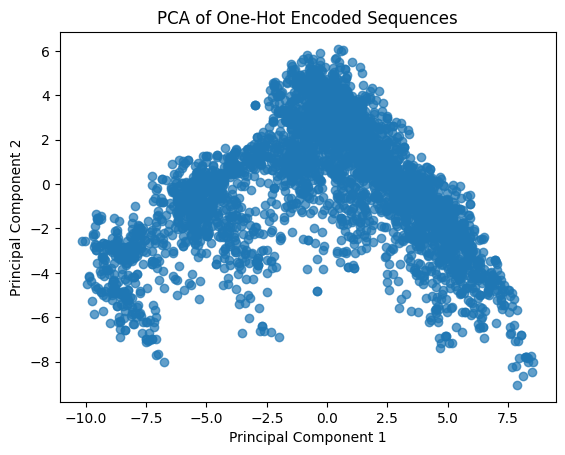

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD



print(seq_aa.shape)
seq_one_hot=np.array([one_hot_seq(seq) for seq in seq_aa[100::10]])
print("shape of one hot encoding",seq_one_hot.shape)
num_sequences, seq_length, num_aa = seq_one_hot.shape
flattened_data = seq_one_hot.reshape(num_sequences, seq_length * num_aa)  # Shape: (num_sequences, seq_length * num_amino_acids)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(flattened_data)

n_components = 2  # Adjust based on how much dimensionality reduction you want
svd = PCA(n_components=n_components)
pca_result_gen = svd.fit_transform(scaled_data)
print(pca_result_gen)
plt.scatter(pca_result_gen[:, 0], pca_result_gen[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of One-Hot Encoded Sequences")
plt.show()
    

shape of one hot encoding (4000, 63, 21)
[[-9.39245697 -1.425239  ]
 [-9.49042495 -1.53030728]
 [-9.55489646 -1.59327168]
 ...
 [-0.69738587  3.11860682]
 [-0.67084623  2.91522081]
 [-0.11913349  3.00170076]]


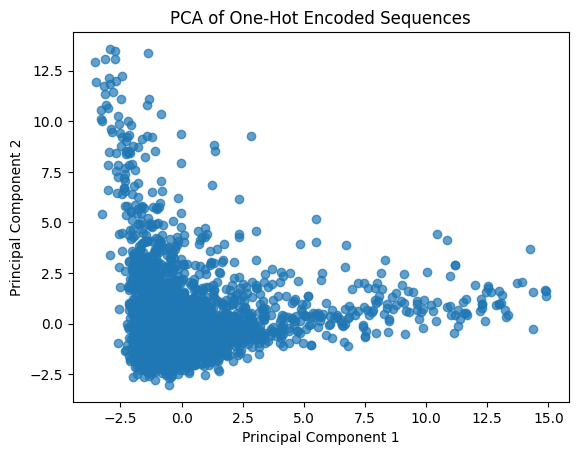

In [17]:
seq_one_hot_ar=np.array([one_hot_seq(seq) for seq in seq_aa_auto_reg])
print("shape of one hot encoding",seq_one_hot_ar.shape)
num_sequences, seq_length, num_aa = seq_one_hot_ar.shape
flattened_data = seq_one_hot_ar.reshape(num_sequences, seq_length * num_aa)  # Shape: (num_sequences, seq_length * num_amino_acids)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(flattened_data)

n_components = 2  # Adjust based on how much dimensionality reduction you want
svd = PCA(n_components=n_components)
pca_result_gen_ar = svd.fit_transform(scaled_data)
print(pca_result_gen)
plt.scatter(pca_result_gen_ar[:, 0], pca_result_gen_ar[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of One-Hot Encoded Sequences")
plt.show()

PCA test

shape of one hot encoding (14502, 63, 21)
[[ 1.73045278 -3.09271427]
 [-5.36683527  0.35053291]
 [ 6.05400464 13.16116765]
 ...
 [-0.98878622  0.68014995]
 [-1.0985434   0.80187167]
 [-5.39417711 -0.08846926]]


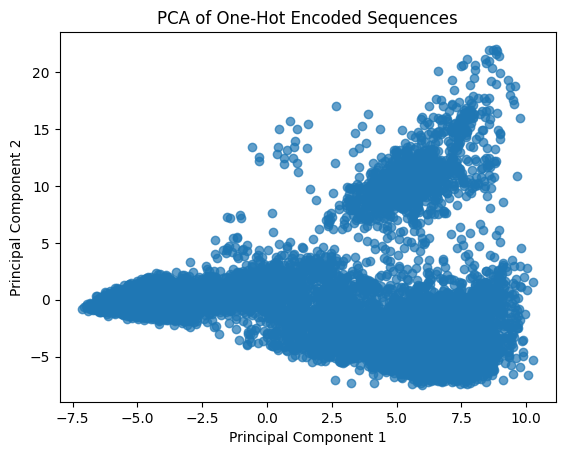

In [18]:

seq_data_test_one_hot=np.array([one_hot_seq(seq) for seq in seq_data_test_filtered])
print("shape of one hot encoding",seq_data_test_one_hot.shape)
num_sequences, seq_length, num_aa = seq_data_test_one_hot.shape
flattened_data = seq_data_test_one_hot.reshape(num_sequences, seq_length * num_aa)  # Shape: (num_sequences, seq_length * num_amino_acids)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(flattened_data)

n_components = 2  # Adjust based on how much dimensionality reduction you want
svd = PCA(n_components=n_components)
pca_result = svd.fit_transform(scaled_data)
print(pca_result)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of One-Hot Encoded Sequences")
plt.show()

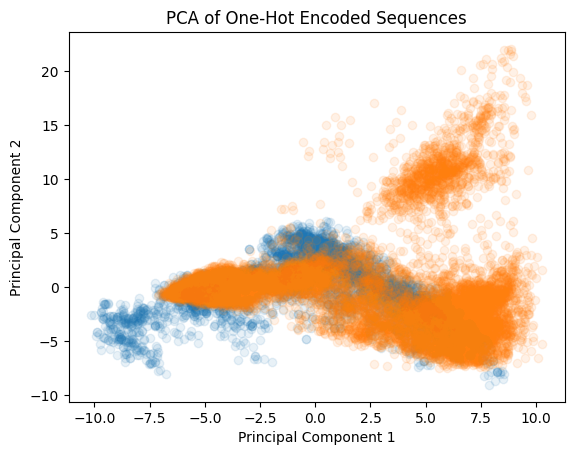

In [20]:
plt.scatter(pca_result_gen[:, 0], pca_result_gen[:, 1], alpha=0.1)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.1)
plt.title("PCA of One-Hot Encoded Sequences")
plt.show()

(4000, 63)
(14502, 63)


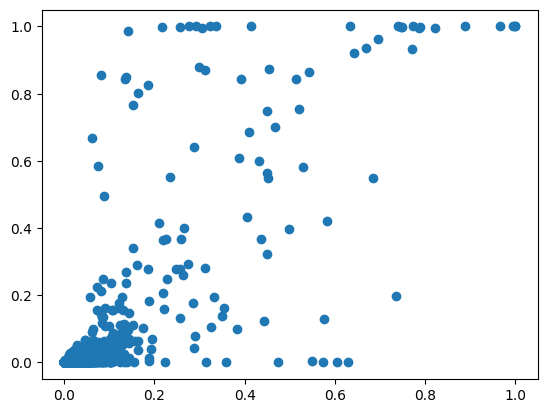

In [22]:

def compute_position_frequencies(sequence_array, n_amino_acids=None):
    """
    Computes frequency of each amino acid at each position.

    Parameters:
        sequence_array (np.ndarray): shape (n_sequences, sequence_length),
                                     where each value is an integer representing an amino acid.
        n_amino_acids (int, optional): total number of possible amino acids.
                                       If None, inferred from max value in array.

    Returns:
        np.ndarray: shape (sequence_length, n_amino_acids), where each entry [i, j]
                    is the frequency of amino acid j at position i.
    """
    n_sequences, seq_length = sequence_array.shape
    if n_amino_acids is None:
        n_amino_acids = int(sequence_array.max()) + 1  # assumes 0-based encoding

    freq_matrix = np.zeros((seq_length, n_amino_acids), dtype=float)

    for pos in range(seq_length):
        counts = np.bincount(sequence_array[:, pos], minlength=n_amino_acids)
        freq_matrix[pos] = counts / n_sequences  # convert to frequencies

    return freq_matrix



def compute_pairwise_frequencies(seq_array, n_amino_acids=None):
    """
    Computes pairwise frequency f_{ij}(a, b) for all positions i, j and amino acids a, b.

    Parameters:
        seq_array (np.ndarray): shape (n_sequences, sequence_length),
                                with integers representing amino acids.
        n_amino_acids (int, optional): number of distinct amino acids (if not known, inferred).

    Returns:
        np.ndarray: shape (sequence_length, sequence_length, n_amino_acids, n_amino_acids)
                    with joint frequencies f_{ij}(a, b)
    """
    n_sequences, seq_len = seq_array.shape
    if n_amino_acids is None:
        n_amino_acids = int(seq_array.max()) + 1  # assumes 0-based encoding

    freq_matrix = np.zeros((seq_len, seq_len, n_amino_acids, n_amino_acids), dtype=float)

    for s in seq_array:
        for i in range(seq_len):
            a = s[i]
            for j in range(seq_len):
                b = s[j]
                freq_matrix[i, j, a, b] += 1

    # Normalize to get frequencies
    freq_matrix /= n_sequences
    return freq_matrix


freq_mat_gen=compute_position_frequencies(seq_aa)
print(seq_aa_auto_reg.shape)
freq_mat_data_train=compute_position_frequencies(seq_data_test_filtered)
print(seq_data_test_filtered.shape)
freq_mat_gen=np.reshape(freq_mat_gen,-1)
freq_mat_data_train=np.reshape(freq_mat_data_train,-1)
plt.scatter(freq_mat_data_train,freq_mat_gen)
plt.show()